# Hex plot of persistence pairs
Author: Amish Mishra  
Date: July 4, 2023  
Use kernel `cder1`
This notebook generates a hexplot of the regions of difference in the persistence pairs of an example topology.
This is meant to be an introductory plot in the paper to give motivation to why we use CDER.

In [79]:
import time
import pickle
import pandas
import numpy as np
from sklearn import metrics
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import SymLogNorm

In [80]:
def stability_threshold_labeller(label_col_value, thresh=1.0):
    '''
    Takes a stability score and returns a lable for it depending on a threshold
    '''
    if label_col_value > thresh:
        return "green"
    else:
        return "red"
    

def preprocess_pd(pd, skew=False, filter='top', t=10):
    """
    Transform a diagram into birth-death coordinates and/or filter out low persistence pairs
    :param pd: Nx2 numpy array of persistence pairs
    :param skew: boolean flag to return point clouds in birth-death coordinates or birth-persistence coordinates
    :param filter: string specifying the type of filtering to do
                   'top': retain at most the t most persistent pairs,
                   'threshold': retain pairs with persistence above t
    :param t: value of filtering parameter
    :return: the processed pd, the number of pairs retained
    """
    num_pairs = None
    if pd.shape[1] == 1:  # This is the case for the H_0 persistence pairs which are 1-dim arrays
        pers = pd[:, 0]
    else:
        pers = pd[:, 1] - pd[:, 0]
        
    if filter == 'threshold':
        pd_new = pd[pers > t, :]
    elif filter == 'all':
        pd_new = pd
        num_pairs = len(pd)
    elif filter == 'top':
        pd_new = pd[np.argsort(pers), :]
        if len(pers) > t:
            pd_new = pd_new[len(pers)-t:, :]
        num_pairs = t
    elif filter == 'random_pairs':
        number_of_rows = pd.shape[0]
        random_indices = np.random.choice(number_of_rows, size=t, replace=False)
        pd_new = pd[random_indices, :]
    elif filter == 'random_percent':
        number_of_rows = pd.shape[0]
        num_pairs = int(np.ceil(number_of_rows*t))
        random_indices = np.random.choice(number_of_rows, size=num_pairs, replace=False)
        pd_new = pd[random_indices, :]

    # convert pd to (birth, persistence) pairs
    if skew and pd.shape[1] != 1:
        pd_new[:, 1] = pd_new[:, 1] - pd_new[:, 0]
    return pd_new, num_pairs


def preprocess_pd_array(pd_array, skew=False, filter='top', t=10):
    """
    Transform the diagrams contained in a diagram array whose keys are equal to homological dimension
    into birth-death coordinates and/or filter out low persistence pairs
    :param pd_array: array of persistence diagrams in a fixed dimention, i.e. value in one entry in the 
                     the dictionary output of load_pd_pcs()
    :param skew: boolean flag to return point clouds in birth-death coordinates or birth-persistence coordinates
    :param filter: string specifying the type of filtering to do 
                   'top': retain at most the t most persistent pairs,
                   'threshold': retain pairs with persistence above t
    :param t: value of filtering parameter
    :return: the processed pd array, the number of pairs retained in each pd
    """
    pd_array_new = []
    num_pairs_arr = []
    # loop over each diagram in the list of diagrams in this dimension and process
    for pd in pd_array:
        filtered_pd, num_pairs_retained = preprocess_pd(pd, skew=skew, filter=filter, t=t)
        pd_array_new.append(filtered_pd)
        num_pairs_arr.append(num_pairs_retained)
    
    return pd_array_new, num_pairs_arr

def round_array(arr):
    '''define a function to round each element of an array to two decimal places'''
    return np.round(arr, 2)

## Load in the dataframe with protein information  
red: unstable  
green: stable

In [81]:
raw_df = pandas.read_csv('main_df.csv')
topologies_arr = raw_df['topology'].unique()  # store the different topology types

# Label stable: green and unstable: red
stability_threshold = 1.0  # set the stability score at which to separate the stable label from the unstable label
label_col = raw_df['stabilityscore_cnn_calibrated'].apply(stability_threshold_labeller, thresh = stability_threshold)
raw_df.insert(loc=2, column='label', value=label_col)  # insert new label column in the 2nd index position
raw_df

,topology,stabilityscore_cnn_calibrated,label,pd_path,name,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,...,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,HHH,0.542808,red,./protein_pds/HHH_rd1_0825.pkl,HHH_rd1_0825,6.0,9.0,-5.0,13.0,9.0,...,5.0,-2.635028,1.00,0.764841,5.3591,-113.306191,15,0.333333,1.5963,0.3444
1,EEHEE,1.687863,green,./protein_pds/EEHEE_rd4_0226.pkl,EEHEE_rd4_0226,4.0,2.0,-2.0,4.0,2.0,...,7.0,-3.385700,1.00,0.786320,9.6969,-145.585091,6,0.200000,3.0023,0.5696
2,HEEH,-0.325246,red,./protein_pds/HEEH_rd2_0035.pkl,HEEH_rd2_0035,3.0,5.0,-5.0,9.0,7.0,...,8.0,-2.240384,1.00,0.764385,12.5276,-96.336497,11,0.750000,4.6847,1.1061
3,EHEE,0.244920,red,./protein_pds/EHEE_rd3_0179.pkl,EHEE_rd3_0179,4.0,1.0,1.0,3.0,-1.0,...,5.0,-2.048340,1.00,0.781405,8.5412,-81.933599,8,0.250000,2.8469,0.5045
4,EEHEE,0.985595,red,./protein_pds/EEHEE_rd3_1627.pkl,EEHEE_rd3_1627,4.0,1.0,-1.0,3.0,3.0,...,5.0,-2.640597,1.00,0.764510,9.7160,-113.545656,6,0.200000,3.0599,0.6737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16169,EEHEE,-0.042749,red,./protein_pds/EEHEE_rd3_0672.pkl,EEHEE_rd3_0672,5.0,1.0,-1.0,3.0,1.0,...,7.0,-2.339757,1.00,0.766706,13.7124,-100.609572,6,0.600000,4.4130,0.8748
16170,HEEH,-0.037665,red,./protein_pds/HEEH_rd1_0808.pkl,HEEH_rd1_0808,6.0,3.0,-3.0,7.0,3.0,...,6.0,-2.275365,0.75,0.680462,22.1786,-97.840676,12,0.500000,9.0900,2.0749
16171,HHH,1.815568,green,./protein_pds/HHH_rd3_0061.pkl,HHH_rd3_0061,6.0,5.0,-1.0,8.0,2.0,...,3.0,-2.766525,1.00,0.811374,6.0599,-118.960588,9,0.000000,1.5719,0.2963
16172,EEHEE,0.681623,red,./protein_pds/EEHEE_rd4_0744.pkl,EEHEE_rd4_0744,1.0,0.0,0.0,2.0,2.0,...,8.0,-3.088340,1.00,0.762311,10.8362,-132.798628,6,0.600000,3.3353,0.6535


## Downsample the unstable and stable proteins 
Select the same number of unstable and stable proteins based on a threshold for the stable proteins

In [82]:
stable_proportion = 1  # determines what portion of the stable proteins to use
max_num = 10000  # max number of proteins to pick for each topology

main_df = pandas.DataFrame(columns = raw_df.columns)
for top in topologies_arr:
    temp_df = raw_df.groupby('topology').get_group(top)
    num_stable = sum(temp_df['stabilityscore_cnn_calibrated'] > stability_threshold)
    num_unstable = sum(temp_df['stabilityscore_cnn_calibrated'] <= stability_threshold)
    stable_num_to_choose = int(stable_proportion*(num_stable))
    if (stable_num_to_choose > max_num):
        stable_num_to_choose = max_num  # choose no more than the allowed max
    if (num_unstable < stable_num_to_choose):
        unstable_num_to_choose = num_unstable  # set max on unstable proteins
    else:
        unstable_num_to_choose = stable_num_to_choose  
    print('Choosing', stable_num_to_choose, 'stable designs out of', num_stable,'for', top)
    print('Choosing', unstable_num_to_choose, 'unstable designs out of', num_unstable, 'for', top)
    
    most_stable = temp_df.nlargest(n=stable_num_to_choose, columns='stabilityscore_cnn_calibrated')
    least_stable = temp_df.nsmallest(n=unstable_num_to_choose, columns='stabilityscore_cnn_calibrated')
    most_stable = most_stable.reset_index(drop=True)
    least_stable = least_stable.reset_index(drop=True)
    main_df = pandas.concat([main_df, most_stable, least_stable])
    
main_df = main_df.reset_index(drop=True)
main_df

Choosing 1346 stable designs out of 1346 for HHH
Choosing 1123 unstable designs out of 1123 for HHH
Choosing 579 stable designs out of 579 for EEHEE
Choosing 579 unstable designs out of 4669 for EEHEE
Choosing 118 stable designs out of 118 for HEEH
Choosing 118 unstable designs out of 4872 for HEEH
Choosing 679 stable designs out of 679 for EHEE
Choosing 679 unstable designs out of 2788 for EHEE


,topology,stabilityscore_cnn_calibrated,label,pd_path,name,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,...,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,HHH,2.675084,green,./protein_pds/HHH_rd4_0122.pkl,HHH_rd4_0122,1.0,7.0,-5.0,12.0,10.0,...,8.0,-3.233831,1.0,0.778585,5.9791,-139.054743,12,1.000000,1.6708,0.3360
1,HHH,2.663947,green,./protein_pds/HHH_rd4_0395.pkl,HHH_rd4_0395,2.0,6.0,-2.0,11.0,7.0,...,7.0,-3.185288,1.0,0.763438,5.4102,-136.967366,13,0.666667,1.4301,0.2915
2,HHH,2.614201,green,./protein_pds/HHH_rd4_0616.pkl,HHH_rd4_0616,1.0,5.0,-5.0,10.0,10.0,...,8.0,-3.044371,1.0,0.810521,4.7901,-130.907940,11,1.000000,1.3618,0.2776
3,HHH,2.613560,green,./protein_pds/HHH_rd4_0228.pkl,HHH_rd4_0228,2.0,7.0,-5.0,11.0,9.0,...,7.0,-3.183216,1.0,0.800401,5.7477,-136.878274,11,0.666667,1.7759,0.3556
4,HHH,2.610852,green,./protein_pds/HHH_rd4_0200.pkl,HHH_rd4_0200,1.0,8.0,-8.0,13.0,13.0,...,7.0,-2.959163,1.0,0.754055,4.8332,-127.244005,9,0.666667,1.3956,0.3211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,EHEE,-0.339017,red,./protein_pds/EHEE_rd3_0150.pkl,EHEE_rd3_0150,2.0,2.0,-2.0,4.0,4.0,...,6.0,-2.169682,1.0,0.743881,8.4475,-86.787270,10,0.500000,2.9030,0.5982
5217,EHEE,-0.338700,red,./protein_pds/EHEE_rd2_0138.pkl,EHEE_rd2_0138,2.0,2.0,-2.0,4.0,2.0,...,6.0,-2.093887,1.0,0.709368,10.7777,-83.755489,9,0.500000,3.2715,0.6825
5218,EHEE,-0.338568,red,./protein_pds/EHEE_rd1_0979.pkl,EHEE_rd1_0979,1.0,2.0,-2.0,5.0,3.0,...,5.0,-2.078602,1.0,0.690610,11.1954,-83.144086,9,0.250000,3.8579,0.7602
5219,EHEE,-0.338040,red,./protein_pds/EHEE_rd2_0847.pkl,EHEE_rd2_0847,3.0,1.0,-1.0,3.0,3.0,...,5.0,-2.209677,1.0,0.684763,10.6580,-88.387069,7,0.250000,3.5946,0.7080


## Load in persistence diagrams

In [83]:
path = './protein_pds/'
filter_type = 'all'  # use all of the persistence pairs from the PD
subsample_size = 'all'  # use all
topology = 'EEHEE'
dim = 1
    
topology_df = main_df[main_df['topology'] == topology]
train_df = pandas.DataFrame()

for l in ['red', 'green']:
    train = topology_df[topology_df['label']==l][['label', 'pd_path']]
    train_df = pandas.concat([train_df, train])

train_hom_all_pds = []
# load in raw hom diagrams
for path in train_df['pd_path']:
    pd_hom = np.load(path, allow_pickle=True)[dim]
    train_hom_all_pds.append(pd_hom)

num_red = len(train_df[train_df['label'] == 'red'])
    
train_proc_hom_all_pds, num_hom_pairs_retained_train = preprocess_pd_array(train_hom_all_pds, skew=True, filter=filter_type, t=subsample_size)
red_pts = train_proc_hom_all_pds[:num_red]
green_pts = train_proc_hom_all_pds[num_red:]

## Plot the hex plot

In [84]:
plotting_df = pandas.DataFrame()#columns=['birth', 'persistence', 'label'])
# plotting_df = plotting_df.reset_index(drop=True)
for pts in red_pts:
    df = pandas.DataFrame(pts)
    red_labels = pandas.DataFrame(np.array(['red']*len(pts)))
    df = pandas.concat([df, red_labels], axis=1)
    df = df.rename(columns={0:'birth', 1:'persistence', 2:'label'})
    plotting_df = pandas.concat([plotting_df, df], ignore_index=True)
    
for pts in green_pts:
    df = pandas.DataFrame(pts)
    red_labels = pandas.DataFrame(np.array(['green']*len(pts)))
    df = pandas.concat([df, red_labels], axis=1)
    df = df.rename(columns={0:'birth', 1:'persistence', 2:'label'})
    plotting_df = pandas.concat([plotting_df, df], ignore_index=True)

plotting_df.columns = ['birth', 'persistence', 'label']
plotting_df = plotting_df.reset_index(drop=True)
display(plotting_df.head())

,birth,persistence,label
0,-1.146553,0.780764,red
1,-0.213765,0.091444,red
2,-0.055905,0.003914,red
3,-0.034225,0.002059,red
4,0.078692,0.016426,red


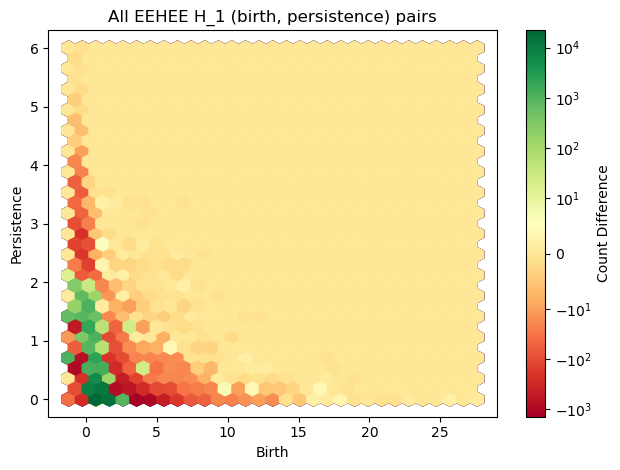

In [85]:
gridsize = 30

# Calculate extent of the hexs
xmax = plotting_df['birth'].max()
xmin = plotting_df['birth'].min()
ymax = plotting_df['persistence'].max()
ymin = plotting_df['persistence'].min()
extent = (xmin, xmax, ymin, ymax)

fig, ax = plt.subplots()
green_df = plotting_df[plotting_df['label'] == 'green']
hexbin_green = ax.hexbin(x=green_df['birth'], y=green_df['persistence'], gridsize=gridsize, extent=(xmin, xmax, ymin, ymax))

red_df = plotting_df[plotting_df['label'] == 'red']
hexbin_red = ax.hexbin(x=red_df['birth'], y=red_df['persistence'], gridsize=gridsize, extent=(xmin, xmax, ymin, ymax))

# Get the hexagon centers
centers = hexbin_green.get_offsets()
counts_g = hexbin_green.get_array()
counts_r = hexbin_red.get_array()
canceled_counts = counts_g - counts_r

# Create a custom colormap from red to white to green
plot = ax.hexbin(centers[:, 0], centers[:, 1], C=canceled_counts, gridsize=gridsize, cmap='RdYlGn', norm=SymLogNorm(linthresh=10))

ax.set_xlabel('Birth')
ax.set_ylabel('Persistence')
ax.set_title(f'All {topology} H_{dim} (birth, persistence) pairs')

# Add a colorbar
plt.colorbar(plot, label='Count Difference')
plt.tight_layout()
plt.show()
